#QUINCY HERSHEY - ALEX MOORE - ADAM DICHIARA - SCOTT TANG - VINCENT FILARDI
#CS541 Project: MAML CNN
---


In [1]:
!pip install learn2learn
!pip install torchmeta

import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import learn2learn as l2l
import torch.utils
from torchmeta.modules import (MetaModule, MetaSequential, MetaConv2d,
                               MetaBatchNorm2d, MetaLinear)
from torchmeta.utils.gradient_based import gradient_update_parameters

colab=True
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Project/data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## RESISC45

---

In [35]:
np.random.seed(1)
random.seed(1)
test_size = 0.8
val_size = 0.2
batch_size = 32
MAML_learning_rate = 0.0006
MAML_learning_rate = 0.0006
CNN_learning_rate = 0.0006
MAML2_learning_rate1=.00045
MAML2_learning_rate2=0.0001/8
n_epochs = 150
print_stride = 10
Freeze=False
First_Train = True
no_load = True
bce_loss = nn.BCELoss()
No_Overlap = False

In [115]:
class CustomTensorDataset(Dataset):

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform=transform

    def __getitem__(self, index):
        X = self.images[index]
        y = self.labels[index]
        return X, y

    def __len__(self):
        return len(self.images)

def make_dataset(x, y):
    x = torch.tensor(x).permute(0,3,1,2)
    y = torch.tensor(y)
    dset = CustomTensorDataset(x, y)
    return dset

In [114]:
def get_data(dir, mtype,nwaykshot=False,No_Overlap=False):
    if mtype=='MAML': batch_n = batch_size*2
    else: batch_n = batch_size

    data = np.load(dir+'RESISC45_images_96.npy')
    labels = np.load(dir+'RESISC45_classes.npy')
    classes = np.load(dir+'RESISC45_class_names.npy')
    if No_Overlap:
        scenes = ['airport',
                  'basketball_court',
                  'bridge',
                  'church',
                  'circular_farmland',
                  'cloud',
                  'commercial_area',
                  'desert',
                  'ground_track_field',
                  'industrial_area',
                  'island',
                  'lake',
                  'meadow',
                  'mountain',
                  'palace',
                  'railway',
                  'railway_station',
                  'rectangular_farmland',
                  'roundabout',
                  'sea_ice',
                  'ship',
                  'snowberg',
                  'stadium',
                  'terrace',
                  'thermal_power_station',
                  'wetland']
        mask = np.isin(classes, scenes)
        classes = classes[mask]
        filterset = np.arange(len(mask))[mask]
        mask = np.isin(labels, filterset)
        labels = labels[mask]
        data = data[mask]
        setlabs = list(set(labels))
        labels = np.array([setlabs.index(x) for x in labels])
    #img_size = train_data.shape[2]
    c_dim = classes.shape[0]

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size, stratify = labels)

    xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size = val_size)
    trainset = make_dataset(xtrain,ytrain)
    train_loader = DataLoader(trainset, batch_size=int(batch_n), shuffle=True)

    valset = make_dataset(xval, yval)
    val_loader = torch.utils.data.DataLoader(valset, batch_n, drop_last = True, shuffle=True)

    testset = make_dataset(test_data, test_labels)
    test_loader = torch.utils.data.DataLoader(testset, batch_n, drop_last = True, shuffle=True)
    if nwaykshot==True:
        return trainset, val_loader, test_loader, c_dim, classes, ytrain
    return train_loader, val_loader, test_loader, c_dim, classes
def tasksplit_uneven(x,y,Params):
    ## split inner and outer loop by incidies
    skip =2 
    idx = idx = torch.arange(start =1, end=x.shape[0]+1).bool()
    idx[::skip] = False
    x_inner = x[idx]
    y_inner = y[idx]
    x_outer = x[~idx]
    y_outer = y[~idx]
    return x_inner, x_outer, y_inner,y_outer

In [5]:

import learn2learn as l2l
def taskStructure(dataset,Params,trainlabels): ## pass train into here
    labels= {}
    for i in range(45):
        labels[i] = [j for j, x in enumerate(trainlabels) if x == i]
    metaDataset = l2l.data.MetaDataset(dataset,labels_to_indices=labels)
    
    transforms = [
    ## need kshots*2 for inner and outer loop split accross each task
        l2l.data.transforms.FusedNWaysKShots(metaDataset,n=Params['nways'],k=Params['kshots']*2,replacement=False),
        l2l.data.transforms.LoadData(metaDataset),
        l2l.data.transforms.ConsecutiveLabels(metaDataset)
    ]
    taskset = l2l.data.TaskDataset(metaDataset,
                                   transforms,
                                   num_tasks=len(dataset)/(Params['nways']*Params['kshots']*2))
        
    return taskset


In [6]:
class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # Input: (batch_size, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(1024)
        
        self.fce = nn.Linear(1024, 45)


    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        x = x/127.5 - 1.0
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))

        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))

        return z

    def save(self, name):
        print('saving...')
        torch.save({
            'model_state_dict': self.state_dict() #,
            #'optimizer_state_dict': self.optimizer.state_dict(),
        }, dir+name+'.pt')

    def load(self, name):
        print('loading...')
        checkpoint = torch.load(dir+name+'.pt')
        self.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


def get_model(mtype, lr=0.0006, train=True,load=False):
    model = Conv_Pred().to(device)
    model.weight_init()
    if load==True:
        try: model.load(mtype)
        except: pass
    if train == True:
        model.train()
    else:
        model.eval()
    return model


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)

def one_hot_embedding(labels, dims):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = dims)
    return torch.squeeze(labels)

def accuracy_topk(output, target, topk=(3,)):
    #https://forums.fast.ai/t/return-top-k-accuracy/27658
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

In [7]:
## for general MAML
class ConvolutionalNeuralNetwork(MetaModule):
    def __init__(self,Params,in_channels=3,out_features=45,hidden_size=2):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = Params['in_channels']
        self.out_features = Params['num_classes']
        self.hidden_size = Params['hidden_size']

        self.features  = MetaSequential(
            MetaConv2d(in_channels,hidden_size**5,kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            MetaConv2d(hidden_size**5,hidden_size**6,kernel_size=4,stride=2,padding=1,bias=False),
            MetaBatchNorm2d(hidden_size**6),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 6, hidden_size ** 7, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size**7),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 7, hidden_size ** 8, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size ** 8),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 8, hidden_size ** 9, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size ** 9),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 9, hidden_size ** 10, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size ** 10),
            nn.ReLU(),
        )
        self.fce = MetaLinear(self.hidden_size**10, out_features)



    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])
    def forward(self, inputs, params=None):
        features = self.features(inputs, params=self.get_subdict(params, 'features'))
        features = features.view((features.size(0), -1))
        logits = self.fce(features, params=self.get_subdict(params, 'classifier'))
        return logits
        
    def save(self, name):
        print('saving...')
        torch.save({
            'model_state_dict': self.state_dict() #,
            #'optimizer_state_dict': self.optimizer.state_dict(),
        }, dir+name+'.pt')

    def load(self, name):
        print('loading...')
        checkpoint = torch.load(dir+name+'.pt')
        self.load_state_dict(checkpoint['model_state_dict'])

def get_meta_model(train=True,load=False):
    model = ConvolutionalNeuralNetwork(Params).to(device)
    model.weight_init()
    if load==True:
        try: model.load(mtype)
        except: pass
    if train == True:
        model.train()
    else:
        model.eval()
    return model

In [8]:
#augmentation_functions.py

class addGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, p=0.5):
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)
        self.p = p
      
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return img + torch.randn(img.size(), device = device) * self.std + self.mean
        return img
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, p={2})'.format(self.mean, self.std, self.p)

def applyAugs(img_batch, task_idx, num_augs=7):
    # returns augmented batch of images based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(96,
                                                   scale=(0.5, 1.0),
                                                   ratio=(0.8, 1.0)),
                                                   #interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)
    img_batch = transform(img_batch)
    return img_batch

def getAugmentationTransforms(task_idx, num_augs=7):
    # returns transforms.Compose function of transforms based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(256,
                                                   scale=(0.5, 1.0),
                                                   ratio=(1.0, 1.0),
                                                   interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)

    return transform

# utility functions
# images must be normalized and converted to torch shape before augmentations (3,h,w)
# converted to numpy shape for displaying (h,w,3)

def normalizeImages(x):
  x = x/255.
  return x

def convertToTorch(x):
  x = np.moveaxis(x, 3, 1)
  x = torch.as_tensor(x)
  return x

def convertToNumpy(x):
  # convert back to format for displaying
  x = x.numpy()
  x = np.moveaxis(x, 1, 3)  
  return x

In [9]:
def train(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype, augs=True, print_stride1=print_stride):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128

    model = get_model(mtype=mtype)
    model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    for epoch in range(1, n_epochs+1):

        losses = []

        for X, y in train_loader:

            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML':

                X1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                X2 = X[int(X.shape[0]/2):].float().clone().to(device)
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)

                task_batch1 = applyAugs(X1, int(i%tasks)).to(device)
                task_batch2 = applyAugs(X2, int(i%tasks)).to(device)
                i += 1

                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch1)
                pred_loss = bce_loss(yhat, y1)
                pred_loss.backward()

                model1_optimizer.step()

                losses += [pred_loss.item()]
                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch2)
                pred_loss = bce_loss(yhat, y2)
                pred_loss.backward()

                for m1, m2 in zip(model.named_parameters(), model1.named_parameters()):
                    m1[1].grad = m2[1].grad.clone()
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)

                if augs: X = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(X)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()

            model_optimizer.step()

            losses += [pred_loss.item()]
            
        
        if epoch % print_stride1 == 0:
            print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

            loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
            with torch.no_grad():
                accs, actk = [], []
                for x, y in val_loader:
                    x, y = x.to(device).float(), y.to(device).float()
                    yhat = model(x)
                    
                    yhat_max = torch.max(yhat, dim = 1)[1]
                    
                    correct = torch.sum(yhat_max == y)
                    size = x.shape[0]
                    
                    acc_topk = accuracy_topk(yhat, y)
                    actk.append(acc_topk.data.item())
                    
                    accs.append(100*(correct/size).data.item())

                print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
                print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
                
            val_accs.append(torch.mean(torch.FloatTensor(accs)))
            val_topks.append(torch.mean(torch.FloatTensor(actk)))
            epoch_tracker.append(epoch)
          
    np.save(dir+mtype+'_loss_tracker.npy', loss_tracker) 
    np.save(dir+mtype+'_val_topks.npy', val_topks)
    np.save(dir+mtype+'_val_accs.npy', val_accs)
    np.save(dir+'epoch_tracker.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker



In [10]:
## MORE MMAML FEATURES N TASK BATCH SIZE AND REGULARIZIAING INNER LOOP TO MIDIGATE FIRST ORDER APROXIMATION
def train2(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype,print_stride1 = print_stride, trainset= None, nwaykshot=False , train_labels = None,Params=None):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128
    alpha=.008
    print(mtype)
    model = get_model(mtype=mtype)
    model_optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0)
    n=32
    for epoch in range(1, n_epochs+1):
        if nwaykshot==True:
                train_loader = taskStructure(trainset,Params,train_labels)
        losses = []
        j=0
        TasksInOuterSum = n
        pred_loss=torch.tensor(0.)
        model3=copy.deepcopy(model).to(device)## we will store all the grads here in this model it will act as a container
        for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o

        for X, y in train_loader:
            i = torch.randint(high=127, size=(1, 1)).item()
            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML2':
                ## I added support for having the outer loop contain multiple tasks, it has been cited by Cheasea finn, 
                #the creator of MAML for fast adaption this is where the model does the most work the outerloop, so we will back load it with 256 images instead of 32
                # This will be done by doing the update of the j variable is a multiple of n, for instance if n is = 8 in the code see line  so we get 8*32=256 images all form same tasks as the inner loop per outer update
                X = applyAugs(X.float().clone().to(device), int(i))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper

                ## data prep for inner and outer loop
                task_batch1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                task_batch2 = X[int(X.shape[0]/2):].float().clone().to(device) ## now each batch
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)
                ## start inner loop
                ## with first order we update the models weights after each inner loop to prevent the hessian update
                ## We wish to find a good intiiallzation point for all tasks so this inner loop should either have a small learning rate or a regularizer
                ## I will use a regulizer to enforce some closeness to the initial point, note te more images we have in the outer loop update step the further we will be 
                ## from the initialization point, ideally maml without any apoximation calls aims to acheive this
                
                ## get logits with the loss for the inner loop
                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1,weight_decay =alpha)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                inner_logit = model1(task_batch1)
                inner_loss = bce_loss(inner_logit, y1)
                inner_loss.backward() ## innner backwards
                model1_optimizer.step() ## inner loss update not on orginal model
                losses += [inner_loss.item()]

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                ## now with the updated_params dict we will take outerloop without updating the params on the inner loop
                outer_logit =  model1(task_batch2) ## get outer logits  with inner loss's params
                outer_loss = bce_loss(outer_logit,y2)
                outer_loss.backward()

                for m1, m2 in zip(model3.named_parameters(), model1.named_parameters()): ## add weights to container
                    m1[1].grad = m1[1].grad + m2[1].grad.clone()

                ## we will now update the model after seeing our n tasks with j%n
                ## time to clone
                if j%TasksInOuterSum ==0:
                    for m1, m2 in zip(model.named_parameters(), model3.named_parameters()):
                        m1[1].grad = m2[1].grad.clone()
                    ## do the update here
                    model_optimizer.step()
                    for param in model.parameters(): param.grad = None
                    for param in model1.parameters(): param.grad = None
                    for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o
                losses += [outer_loss.item()]
    
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)
                task_batch = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(task_batch)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()
                ## moved these inside, We only wish to do it for the cnn
                model_optimizer.step()
            losses += [pred_loss.item()]
            
        
        if epoch % print_stride1 == 0:

            print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

            loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
            with torch.no_grad():
                accs, actk = [], []
                for x, y in val_loader:
                    x, y = x.to(device).float(), y.to(device).float()
                    yhat = model(x)
                    
                    yhat_max = torch.max(yhat, dim = 1)[1]
                    
                    correct = torch.sum(yhat_max == y)
                    size = x.shape[0]

                    acc_topk = accuracy_topk(yhat, y)
                    actk.append(acc_topk.data.item())
                    
                    accs.append(100*(correct/size).data.item())

            print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
            print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
            val_accs.append(torch.mean(torch.FloatTensor(accs)))
            val_topks.append(torch.mean(torch.FloatTensor(actk)))
            epoch_tracker.append(epoch)
    np.save(dir+mtype+'_loss_tracker.npy', loss_tracker) 
    np.save(dir+mtype+'_val_topks.npy', val_topks)
    np.save(dir+mtype+'_val_accs.npy', val_accs)
    np.save(dir+'epoch_tracker.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker




In [145]:
## general mamal train
from torchmeta.utils.gradient_based import gradient_update_parameters
import torch.nn.functional as F


def trainMAML(mtype,model, train_tasks, Params, val_loader, print_stride1, nwaykshot=False, trainset=False,train_labels=False):  ## go through data set


    epoch_tracker, loss_tracker, val_accs, val_topks,trainacc = [], [], [], [],[]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    model.to(device)

    if mtype!='MAMLnk':
        return False

      # keeping track of tasks seen make sure to see entrie dataset

    for epoch in range(1, Params['epoch']+1):

        tracc, trlosses= looptrain(Params,model,train_tasks,nwaykshot,trainset=trainset,train_labels= train_labels)

        trainacc.append(tracc)
        loss_tracker.append(trlosses)
        with torch.no_grad():
            accs, actk = [], []
            for x, y in val_loader:
                x, y = x.to(device).float(), y.to(device).float()
                yhat = model(x)
                
                yhat_max = torch.max(yhat, dim = 1)[1]
                
                correct = torch.sum(yhat_max == y)
                size = x.shape[0]
                
                acc_topk = accuracy_topk(yhat, y)
                actk.append(acc_topk.data.item())
                
                accs.append(100*(correct/size).data.item())
                ac = torch.mean(torch.FloatTensor(accs)).data.item()
                top = torch.mean(torch.FloatTensor(actk)).data.item()
            if epoch%print_stride1==0:
                print('On Epoch ',epoch)
                print('Train Loss', loss_tracker[-1])
                print('Validation Accuracy: ', ac)
                print('Validation Top3 Accuracy: ', top)
            val_accs.append(ac)
            val_topks.append(top)
            epoch_tracker.append(epoch)
        ac = torch.mean(torch.FloatTensor(accs)).data.item()
        top = torch.mean(torch.FloatTensor(actk)).data.item()
        if epoch%20==0:
            Params['MetaLR']*=.5
            Params['innerStep']*=.5
    model.save(mtype)
    return model, epoch_tracker[::print_stride1], loss_tracker[::print_stride1], val_accs[::print_stride1], val_topks[::print_stride1], trainacc[::print_stride1]
def looptrain(Params,model,train_loader,nwaykshot=False,trainset=None,train_labels=None):
    trainacc,trainloss = [], []
    if nwaykshot==True:
        train_loader = taskStructure(trainset,Params,train_labels)
    shape=0
    j = 0
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=Params['MetaLR']*5/64)
    outer_loss = torch.tensor(0., device=device)
    for task in train_loader:
        i = torch.randint(high=127, size=(1, 1)).item()
        model.zero_grad()
        loss_amount = 0 
        ## call augments on the fly
        x, y = task
        shape+= y.shape[0]
        x = x.float().to(device)
        y = y.long().to(device)
        x_inner, x_outer, y_inner, y_outer = tasksplit_uneven(applyAugs(x, i), y,
                                                        Params)  ## split task for inner/ ouyter with same augs
        train_logit = model(x_inner)
        inner_loss = F.cross_entropy(train_logit, y_inner)
        loss_amount += inner_loss.item()
        model.zero_grad()
        params = gradient_update_parameters(model,
                                            inner_loss,
                                            params=None,
                                            step_size=Params["innerStep"]*5/16,
                                            first_order=Params['Order'])
        test_logit = model(x_outer,
                        params=params)  ## take the loss fucntions using the params of this task specific inner loop
        current_outer_loss = F.cross_entropy(test_logit, y_outer)
        outer_loss += current_outer_loss ## sum this inot the outer loop
        current_outer_loss.div_(len(x_outer))
        
        yhat_max = torch.max(test_logit, dim = 1)[1]
        correct = torch.sum(yhat_max == y_outer)
        size = x.shape[0]
        acc = 100*(correct/size).data.item()
        trainacc.append(acc)
        if j % Params['number_of_tasks'] == 0:  ## we hit number of tasks if this =0 then we do the outer loop with the update as a sum 
            outer_loss.backward()
            loss_amount += outer_loss.item()
            meta_optimizer.step()
            outer_loss = torch.tensor(0., device=device)
            for param in model.parameters(): param.grad = None
        elif outer_loss.item()!= 0 and 5040 -shape< 2*Params['nways']*Params['kshots']+33: ## do not waste those computations!
            outer_loss.backward()
            loss_amount += outer_loss.item()
            meta_optimizer.step()
            outer_loss = torch.tensor(0., device=device)
            for param in model.parameters(): param.grad = None
        j += 1
    meta_optimizer.zero_grad()
    model.zero_grad()
    train_accuracy = torch.mean(torch.FloatTensor(trainacc)).data.item()
    train_losses = loss_amount/shape
    return train_accuracy, train_losses

In [12]:
def make_train_plot(MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs, MAML_val_topks, CNN_Aug_val_topks, CNN_val_topks, epoch_tracker,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2,MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topk):
    #plt.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    #plt.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss')
    #plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    plt.figure(figsize = (15,8))
    plt.plot(epoch_tracker, MAML_val_accs, label = 'First order MAML val acc', color='green', linestyle='dashed')
    plt.plot(epoch_tracker, MAML_val_accs2, label = 'First order MAML* val acc', color='orange', linestyle='dashed')

    plt.plot(epoch_tracker, CNN_Aug_val_accs, label = 'CNN Aug val acc', color='blue', linestyle='dashed')
    plt.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc', color='red', linestyle='dashed')
    plt.plot(epoch_tracker, MAML_val_topks, label = 'First order MAML val top3', color='green')
    plt.plot(epoch_tracker, MAML_val_topks2, label = 'First order MAML* val top3', color='orange')

    plt.plot(epoch_tracker, MAML_nk_val_accs, label = 'MAML 32 way 1 shot val acc', color='yellow',linestyle='dashed')
    plt.plot(epoch_tracker, MAML_nk_val_topk, label = 'MAML 32 way 1 shot val top3', color='yellow')
    
    plt.plot(epoch_tracker, CNN_Aug_val_topks, label = 'CNN_Aug_val top3', color='blue')
    plt.plot(epoch_tracker, CNN_val_topks, label = 'CNN_val top3', color='red')
    plt.legend(loc = 'best')
    plt.show()

def make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,8)
    ax1.plot(epoch_tracker, MAML_loss_tracker, label = 'First order MAML train loss', color='green')
    ax1.plot(epoch_tracker, MAML_loss_tracker2, label = 'First order MAML* train loss', color='orange')

    ax1.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss', color='blue')
    ax1.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss', color='red')
    ax1.legend(loc = 'best')
    ax2.plot(epoch_tracker, MAML_val_accs, label = 'First order MAML val acc', color='green')
    ax2.plot(epoch_tracker, MAML_val_accs2, label = 'First order MAML* val acc', color='orange')

    ax2.plot(epoch_tracker, CNN_Aug_val_accs, label = 'CNN Aug val acc', color='blue')
    ax2.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc', color='red')
    ax2.legend(loc = 'best')
    plt.tight_layout()
    plt.show()

def basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker,MAML_loss_tracker2):
    plt.figure(figsize = (15,8))
    plt.plot(epoch_tracker, MAML_loss_tracker, label = 'First order MAML train loss', color='green')
    plt.plot(epoch_tracker, MAML_loss_tracker2, label = 'First order MAML* train loss', color='orange')

    plt.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss', color='blue')
    plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss', color='red')
    plt.legend(loc = 'best')
    plt.show()

def make_test(model, testloader,get_worse=False,plot=False):
    with torch.no_grad():
        model.eval()
        accs, topks, ypreds, yreals = [], [], [], []
        for x, y in testloader:
            x, y = x.to(device).float(), y.to(device).float()
            yhat = model(x)

            yhat_max = torch.max(yhat, dim = 1)[1]

            correct = torch.sum(yhat_max == y)
            size = x.shape[0]
            acc_topk = accuracy_topk(yhat, y)

            ypreds += torch.argmax(yhat, dim=1).tolist()
            yreals += y.tolist()

            topks.append(acc_topk.data.item())
            accs.append(100*(correct/size).data.item())
        test_acc = torch.mean(torch.FloatTensor(accs)).data.item()
        test_topk = torch.mean(torch.FloatTensor(topks)).data.item()
        print('Test Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
        print('Test Top3 Accuracy: ', torch.mean(torch.FloatTensor(topks)).data.item())
        if plot:
            cm = metrics.confusion_matrix(yreals, ypreds)
            fig, ax = plt.subplots(figsize=(15,8))  
            sns.heatmap(cm, cmap='Blues', ax=ax)
        ## get best/worst task
        model.eval()
        if get_worse==True:
            worst,best = get_worst_task(model,testloader)
            print(best,'= Best Task ID ')
            print(worst,'= Worst Task ID ')
            return test_acc, test_topk
    return test_acc, test_topk
        
def get_worst_task(model,val_loader): ## gives percentage rate of correct classification for each aug in our task list, 
                                      ##please check if dict on line below is right size
    bytaskListACCDICT = dict.fromkeys(range(128),0)
    i=0
    model.eval()
    for x,y in val_loader:
        actk,accs = [], []
        x = applyAugs(x.float().clone().to(device), int(i%128))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper
        y = y.float().clone().to(device)
        yhat = model(x) 
        yhat_max = torch.max(yhat, dim = 1)[1]
        correct = torch.sum(yhat_max == y)
        size = x.shape[0]
        acc_topk = accuracy_topk(yhat, y)
        actk.append(acc_topk.data.item())
        
        accs.append(100*(correct/size).data.item())
        bytaskListACCDICT[i%128]+=100*(correct/size).data.item()
        i+=1
    worstTASKid = min(bytaskListACCDICT, key=bytaskListACCDICT.get)
    bestTASKid = max(bytaskListACCDICT, key=bytaskListACCDICT.get)
    return worstTASKid, bestTASKid

def make_example(train_loader, classes):
    #print('Shape of a batch of images: ', next(iter(train_loader))[0].shape)
    #print('Shape of a batch of labels: ', next(iter(train_loader))[1].shape)

    plt.figure(figsize = (8,8))
    first_samp = next(iter(train_loader)) #get first sample in first batch
    img, name = first_samp[0][0], first_samp[1][0]
    plt.imshow(img.permute(1,2,0)/255)

    print(name, classes[name])

## RESISC MAML

Require: $p(\mathcal{T}):$ distribution over tasks 
Require: $\alpha, \beta:$ step size hyperparameters

1: randomly initialize $\theta$

2: while not done $\mathbf{d o}$ 

3: $\quad$ Sample single task $\mathcal{T} \sim p(\mathcal{T})$

5: $\quad$ Evaluate $\nabla_{\theta} \mathcal{L}\left(f_{\theta}(\mathcal{T}_{inner})\right)$ with respect to $K$ examples 

6: $\quad$ Compute adapted parameters with gradient descent: $\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}\left(f_{\theta}(\mathcal{T}_{inner})\right)$

7: $\quad$ Update $\theta \leftarrow \theta-\beta \nabla_{\theta_{i}^{\prime}} \mathcal{L}\left(f_{\theta_{i}^{\prime}} \left(\mathcal{T}_{outer}\right)\right)$

8: end while

---

tensor(32, dtype=torch.int32) river


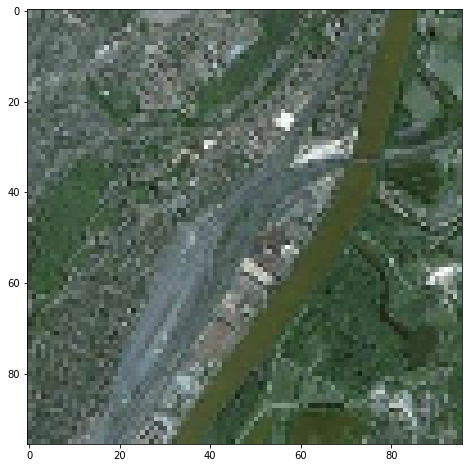

In [36]:
mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

make_example(train_loader=train_loader, classes=classes)

In [37]:
if First_Train: model, MAML_loss_tracker, MAML_val_topks, MAML_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=MAML_learning_rate, 
                                                                learning_rate1=MAML_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    MAML_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs=np.load(dir+mtype+'_val_accs.npy')
    epoch_tracker=np.load(dir+'epoch_tracker.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.094
Validation Accuracy:  18.25657844543457
Validation Top3 Accuracy:  40.37828826904297
Epoch 20 - loss: 0.089
Validation Accuracy:  35.032894134521484
Validation Top3 Accuracy:  57.40131759643555
Epoch 30 - loss: 0.086
Validation Accuracy:  40.21381759643555
Validation Top3 Accuracy:  63.07565689086914
Epoch 40 - loss: 0.084
Validation Accuracy:  39.88486862182617
Validation Top3 Accuracy:  63.48684310913086
Epoch 50 - loss: 0.080
Validation Accuracy:  44.8190803527832
Validation Top3 Accuracy:  69.40789794921875
Epoch 60 - loss: 0.078
Validation Accuracy:  47.03947448730469
Validation Top3 Accuracy:  72.12171173095703
Epoch 70 - loss: 0.076
Validation Accuracy:  53.28947448730469
Validation Top3 Accuracy:  76.23355102539062
Epoch 80 - loss: 0.075
Validation Accuracy:  52.38486862182617
Validation Top3 Accuracy:  75.08223724365234
Epoch 90 - loss: 0.073
Validation Accuracy:  57.894737243652344
Validation Top3 Accuracy:  79.44078826904297
Epoch 100 - loss: 0.071
Val

In [15]:
acc,topk=make_test(model=model, testloader=test_loader)

Test Accuracy:  65.63294982910156
Test Top3 Accuracy:  85.5120849609375


# MAML* first order approximation with support for n task batch and inner l2 regularization to compensate for approximation

Require: $p(\mathcal{T}):$ distribution over tasks 

Require: $\alpha, \beta:$ step size hyperparameters

1: randomly initialize $\theta$

2: while not done $\mathbf{d o}$

3: $\quad$ Sample batch of tasks $\mathcal{T}_{i} \sim p(\mathcal{T})$

4: $\quad$ for all $\mathcal{T}_{i}$ do 

5: $\quad$ $\quad$ Evaluate $\nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right)$ with respect to $K$ examples 

6: $\quad$ $\quad$ Compute adapted parameters with gradient descent: $\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right) + ||\theta||_2$

7: $\quad$ end for

8: $\quad$Update $\theta \leftarrow \theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})} \nabla_{\theta_{i}^{\prime}} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}})\right)$

9: end while




tensor(13, dtype=torch.int32) forest


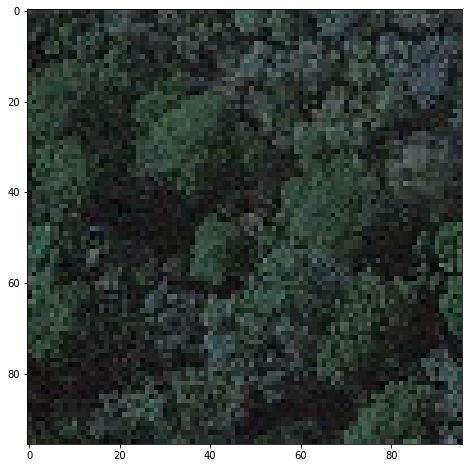

In [16]:
mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

make_example(train_loader=train_loader, classes=classes)
mtype='MAML2'

In [17]:
if First_Train: model, MAML_loss_tracker2, MAML_val_topks2, MAML_val_accs2, epoch_tracker, = train2(n_epochs=n_epochs, 
                                                                learning_rate=0.00045, 
                                                                learning_rate1=0.0001/8, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    MAML_loss_tracker2=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks2=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs2=np.load(dir+mtype+'_val_accs.npy')

MAML2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.058
Validation Accuracy:  29.6875
Validation Top3 Accuracy:  53.125
Epoch 20 - loss: 0.056
Validation Accuracy:  37.25328826904297
Validation Top3 Accuracy:  59.78618240356445
Epoch 30 - loss: 0.055
Validation Accuracy:  43.092105865478516
Validation Top3 Accuracy:  68.33881378173828
Epoch 40 - loss: 0.053
Validation Accuracy:  45.47697448730469
Validation Top3 Accuracy:  68.91447448730469
Epoch 50 - loss: 0.052
Validation Accuracy:  48.68421173095703
Validation Top3 Accuracy:  72.6151351928711
Epoch 60 - loss: 0.049
Validation Accuracy:  55.42763137817383
Validation Top3 Accuracy:  76.80921173095703
Epoch 70 - loss: 0.042
Validation Accuracy:  59.21052551269531
Validation Top3 Accuracy:  79.76973724365234
Epoch 80 - loss: 0.051
Validation Accuracy:  60.36184310913086
Validation Top3 Accuracy:  82.15460205078125
Epoch 90 - loss: 0.047
Validation Accuracy:  61.595394134521484
Validation Top3 Accuracy:  83.14144897460938
Epoch 100 - loss: 0.042
Validation Accuracy:  60

In [18]:
acc,topk=make_test(model=model, testloader=test_loader)


Test Accuracy:  68.39614868164062
Test Top3 Accuracy:  87.49205017089844


## MAML 32 way 1 shot 

In [19]:
Params= Params = {'nways': 32, 'kshots': 1, 'in_channels': 3, 'hidden_size': 2, 
                  'innerStep': 0.00005, 'MetaLR': 0.006, 'number_of_tasks': 32,
                  'Order': False, 'outerVSinner': 1, 'epoch': n_epochs, 'aug': True,
                   'num_classes': 45}
if No_Overlap:
    Params[num_classes]=45
model = get_meta_model(Params)
train_loader, val_loader, test_loader, c_dim, classes, ytrain = get_data(dir=dir, mtype=mtype,nwaykshot=True)
model.to(device)
mtype = 'MAMLnk'

if First_Train: model, epoch_tracker, MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topks, MAML_nk_trainacc = trainMAML(mtype,
                                                                                              model,
                                                                                              train_loader, 
                                                                                              Params, 
                                                                                              val_loader,print_stride1 = print_stride,
                                                                                              nwaykshot=True,
                                                                                              trainset=train_loader,
                                                                                              train_labels=ytrain,
                                                                                              )
else: 
    model = get_model(mtype)
    MAML_nk_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_nk_val_topks=np.load(dir+mtype+'_val_topks.npy')
    MAML_nk_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Module `ConvolutionalNeuralNetwork` has no parameter corresponding to the submodule named `classifier` in the dictionary `params` provided as an argument to `forward()`. Using the default parameters for this submodule. The list of the parameters in `params`: [features.0.weight, features.0.bias, features.2.weight, features.3.weight, features.3.bias, features.5.weight, features.6.weight, features.6.bias, features.8.weight, features.9.weight, features.9.bias, features.11.weight, features.12.weight, features.12.bias, features.14.weight, features.15.weight, features.15.bias, fce.weight, fce.bias].


On Epoch  10
Train Loss 0.008885450135820951
Validation Accuracy:  19.711538314819336
Validation Top3 Accuracy:  41.82692337036133
On Epoch  20
Train Loss 0.008379676212102938
Validation Accuracy:  29.727563858032227
Validation Top3 Accuracy:  51.60256576538086
On Epoch  30
Train Loss 0.00877872090309094
Validation Accuracy:  37.5
Validation Top3 Accuracy:  58.97435760498047
On Epoch  40
Train Loss 0.006741923757661612
Validation Accuracy:  39.42307662963867
Validation Top3 Accuracy:  63.78205108642578
On Epoch  50
Train Loss 0.007087628524272869
Validation Accuracy:  41.987178802490234
Validation Top3 Accuracy:  66.82691955566406
On Epoch  60
Train Loss 0.00755286233451886
Validation Accuracy:  42.14743423461914
Validation Top3 Accuracy:  68.66986846923828
On Epoch  70
Train Loss 0.007926523016813474
Validation Accuracy:  45.753204345703125
Validation Top3 Accuracy:  68.34935760498047
On Epoch  80
Train Loss 0.005669849948623242
Validation Accuracy:  45.59294891357422
Validation Top3 

In [20]:
acc,topk=make_test(model=model, testloader=test_loader)

Test Accuracy:  53.061466217041016
Test Top3 Accuracy:  75.40898895263672


## RESISC CNN with Augs

---

In [22]:
mtype='CNN_Aug'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

if First_Train: model, CNN_Aug_loss_tracker, CNN_Aug_val_topks, CNN_Aug_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=CNN_learning_rate, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    CNN_Aug_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    CNN_Aug_val_topks=np.load(dir+mtype+'_val_topks.npy')
    CNN_Aug_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.086
Validation Accuracy:  34.855770111083984
Validation Top3 Accuracy:  58.49359130859375
Epoch 20 - loss: 0.082
Validation Accuracy:  43.269229888916016
Validation Top3 Accuracy:  68.02884674072266
Epoch 30 - loss: 0.075
Validation Accuracy:  47.355770111083984
Validation Top3 Accuracy:  70.91345977783203
Epoch 40 - loss: 0.068
Validation Accuracy:  54.32692337036133
Validation Top3 Accuracy:  75.96154022216797
Epoch 50 - loss: 0.073
Validation Accuracy:  58.97435760498047
Validation Top3 Accuracy:  79.6474380493164
Epoch 60 - loss: 0.074
Validation Accuracy:  61.53845977783203
Validation Top3 Accuracy:  82.21154022216797
Epoch 70 - loss: 0.068
Validation Accuracy:  58.5737190246582
Validation Top3 Accuracy:  81.00961303710938
Epoch 80 - loss: 0.064
Validation Accuracy:  67.1474380493164
Validation Top3 Accuracy:  85.01602935791016
Epoch 90 - loss: 0.063
Validation Accuracy:  63.94230651855469
Validation Top3 Accuracy:  84.61538696289062
Epoch 100 - loss: 0.065
Vali

In [23]:
acc,topk = make_test(model=model, testloader=test_loader,get_worse=True)

Test Accuracy:  71.9663314819336
Test Top3 Accuracy:  88.92948150634766
2 = Best Task ID 
77 = Worst Task ID 


## RESISC CNN no Augs

---

In [24]:
mtype='CNN'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

if First_Train: model, CNN_loss_tracker, CNN_val_topks, CNN_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=CNN_learning_rate, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,
                                                                augs=False,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    CNN_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    CNN_val_topks=np.load(dir+mtype+'_val_topks.npy')
    CNN_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.000
Validation Accuracy:  38.862178802490234
Validation Top3 Accuracy:  58.49359130859375
Epoch 20 - loss: 0.000
Validation Accuracy:  36.6987190246582
Validation Top3 Accuracy:  58.012821197509766
Epoch 30 - loss: 0.000
Validation Accuracy:  35.737178802490234
Validation Top3 Accuracy:  57.45192337036133
Epoch 40 - loss: 0.000
Validation Accuracy:  35.65705108642578
Validation Top3 Accuracy:  58.17307662963867
Epoch 50 - loss: 0.000
Validation Accuracy:  35.25640869140625
Validation Top3 Accuracy:  56.89102554321289
Epoch 60 - loss: 0.000
Validation Accuracy:  35.096153259277344
Validation Top3 Accuracy:  56.16987228393555
Epoch 70 - loss: 0.055
Validation Accuracy:  29.887821197509766
Validation Top3 Accuracy:  50.160255432128906
Epoch 80 - loss: 0.000
Validation Accuracy:  32.45192337036133
Validation Top3 Accuracy:  53.68589782714844
Epoch 90 - loss: 0.000
Validation Accuracy:  32.69230651855469
Validation Top3 Accuracy:  54.00640869140625
Epoch 100 - loss: 0.002

In [25]:
acc,topk = make_test(model=model, testloader=test_loader,get_worse=True)

Test Accuracy:  30.904542922973633
Test Top3 Accuracy:  50.68694305419922
32 = Best Task ID 
27 = Worst Task ID 


## RESISC CHARTS

---

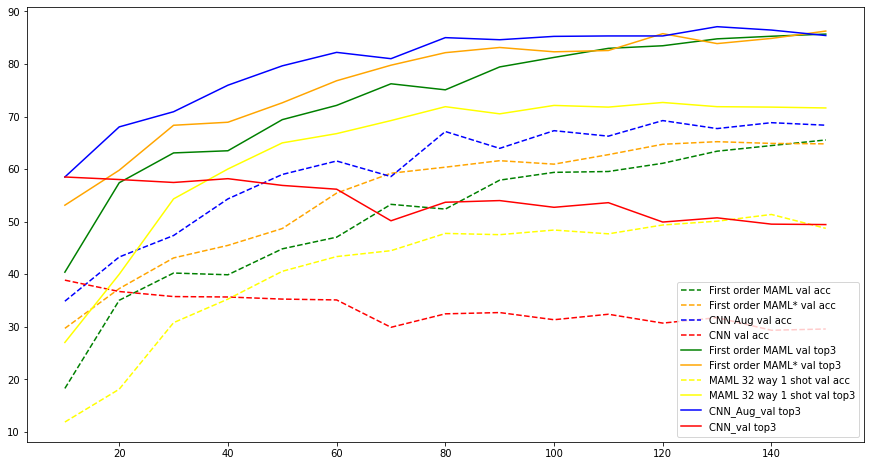

In [38]:
make_train_plot(MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs, MAML_val_topks, CNN_Aug_val_topks, CNN_val_topks, epoch_tracker,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2,MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topks
)

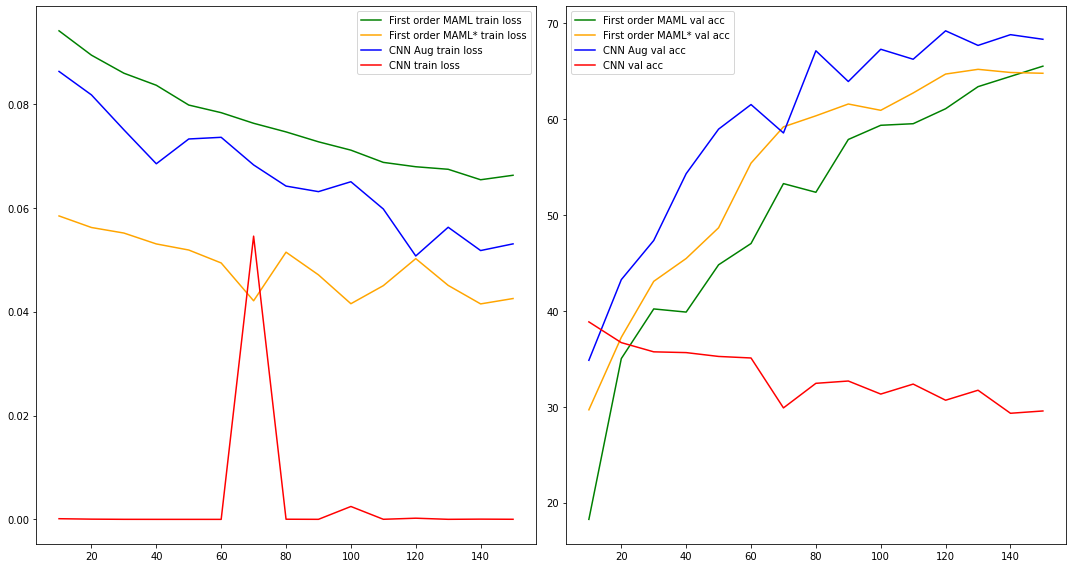

In [39]:
make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2)

## UC MERCED

---

In [28]:
UC_MAML_learning_rate = 0.0006
UC_CNN_learning_rate = 0.0006
UC_epochs = 3
UC_batch_size = 32

UC_data = np.load(dir+'UCMerced_images96.npy')
UC_labels = np.load(dir+'UCMerced_classes.npy')
UC_classes = np.load(dir+'UCMerced_class_names.npy')

UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

UCtrainset = make_dataset(UC_train_data, UC_train_labels)
UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

UCtestset = make_dataset(UC_test_data, UC_test_labels)
UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)

def UC_get_data():
    UC_data = np.load(dir+'UCMerced_images96.npy')
    UC_labels = np.load(dir+'UCMerced_classes.npy')
    UC_classes = np.load(dir+'UCMerced_class_names.npy')

    UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

    UCtrainset = make_dataset(UC_train_data, UC_train_labels)
    UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

    UCtestset = make_dataset(UC_test_data, UC_test_labels)
    UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)
    return UCtrain_loader, UCtest_loader

In [42]:
def UC_train(model1, trainloader, epochs=3, lr=0.0006):
    loss_tracker, epoch_tracker,acc_tracker = [], [], []
    #model.load('UC')
    model = copy.deepcopy(model1).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    for epoch in range(1, epochs+1):
        losses = 0
        accs = []
        acc = 0

        for X, y in trainloader:
            y_ = y 
            y = one_hot_embedding(y.to(device), len(UC_classes)).float()
            X = X.float().to(device)
            for param in model.parameters(): param.grad = None
            yhat = model(X)
            pred_loss = bce_loss(yhat, y)
            pred_loss.backward()
            optimizer.step()
            losses += pred_loss.item()
           
        for x, y in trainloader:
            x, y = x.to(device).float(), y.to(device).float()
            yhat = model(x)
            
            yhat_max = torch.max(yhat, dim = 1)[1]
            correct = torch.sum(yhat_max == y)
            size = x.shape[0]            
            accs.append(100*(correct/size).data.item())
        print('UC Epoch ',epoch,"Train Accuracy: ",torch.mean(torch.FloatTensor(accs)).data.item())
        acc_tracker.append(torch.mean(torch.FloatTensor(accs)).data.item())
        epoch_tracker.append(epoch)
        loss_tracker.append(losses)
    return model, epoch_tracker, loss_tracker,acc_tracker
def avg_UC_test(mtype,runs):
    model1 = get_model(mtype=mtype,load=True)
    test_acc,test_topk = [], [] 
    for _ in range(runs):
        model= copy.deepcopy(model1.to('cpu')).to(device)
        UC_MAML_learning_rate = 0.0006
        UC_CNN_learning_rate = 0.0006
        UC_epochs = 3
        UC_batch_size = 32
        UCtrain_loader,UCtest_loader = UC_get_data()
        model.fce = nn.Linear(1024, 21)
        model = model.to(device)
        model, epoch_tracker, CNN_Aug_loss_tracker,CNN_AUG_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)
        acc,topk =make_test(model=model, testloader=UCtest_loader,get_worse=False)
        test_acc.append(acc)
        test_topk.append(topk)
    print(mtype + 'Accuracy on UC as an avg of ',runs,": ",np.mean(test_acc))
    print(mtype + 'TopK on UC as an avg of ',runs,": ",np.mean(test_topk))

In [43]:
mtype='MAML'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, MAML_loss_tracker, MAML_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.16964340209961
UC Epoch  2 Train Accuracy:  75.66963958740234
UC Epoch  3 Train Accuracy:  90.17857360839844


In [44]:
acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('MAML',20)


Test Accuracy:  71.09375
Test Top3 Accuracy:  90.625
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.20536041259766
UC Epoch  2 Train Accuracy:  76.33928680419922
UC Epoch  3 Train Accuracy:  88.39286041259766
Test Accuracy:  71.75480651855469
Test Top3 Accuracy:  91.64663696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.75
UC Epoch  2 Train Accuracy:  82.36607360839844
UC Epoch  3 Train Accuracy:  86.83036041259766
Test Accuracy:  70.61298370361328
Test Top3 Accuracy:  90.98558044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.83928680419922
UC Epoch  2 Train Accuracy:  85.9375
UC Epoch  3 Train Accuracy:  87.94642639160156
Test Accuracy:  71.21394348144531
Test Top3 Accuracy:  92.42788696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.85713958740234
UC Epoch  2 Train Accuracy:  84.375
UC Epoch  3 Train Accuracy:  86.60713958740234
Test Accuracy:  73.49759674072266
Test Top3 Accuracy:  92.60816955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.20536041259766
UC Epoch  2 Train Accuracy:  83.25892639160156
UC Epoch  3 Train Accuracy:  87.72321319580078
Test Accuracy:  72.89663696289062
Test Top3 Accuracy:  91.88701629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.41071319580078
UC Epoch  2 Train Accuracy:  85.49107360839844
UC Epoch  3 Train Accuracy:  89.28571319580078
Test Accuracy:  73.49759674072266
Test Top3 Accuracy:  92.78845977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.41071319580078
UC Epoch  2 Train Accuracy:  80.58036041259766
UC Epoch  3 Train Accuracy:  91.96428680419922
Test Accuracy:  72.65625
Test Top3 Accuracy:  91.52644348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.85713958740234
UC Epoch  2 Train Accuracy:  85.49107360839844
UC Epoch  3 Train Accuracy:  89.73213958740234
Test Accuracy:  71.51441955566406
Test Top3 Accuracy:  90.86538696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.30357360839844
UC Epoch  2 Train Accuracy:  83.70536041259766
UC Epoch  3 Train Accuracy:  91.74107360839844
Test Accuracy:  73.49759674072266
Test Top3 Accuracy:  93.02884674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  64.95536041259766
UC Epoch  2 Train Accuracy:  83.92857360839844
UC Epoch  3 Train Accuracy:  91.96428680419922
Test Accuracy:  74.21875
Test Top3 Accuracy:  92.36779022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.76786041259766
UC Epoch  2 Train Accuracy:  86.60713958740234
UC Epoch  3 Train Accuracy:  93.30357360839844
Test Accuracy:  70.55288696289062
Test Top3 Accuracy:  91.76683044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.08036041259766
UC Epoch  2 Train Accuracy:  81.47321319580078
UC Epoch  3 Train Accuracy:  90.84821319580078
Test Accuracy:  73.91826629638672
Test Top3 Accuracy:  92.66826629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  62.27678680419922
UC Epoch  2 Train Accuracy:  83.03571319580078
UC Epoch  3 Train Accuracy:  93.75
Test Accuracy:  75.60095977783203
Test Top3 Accuracy:  92.78845977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.97321319580078
UC Epoch  2 Train Accuracy:  85.26786041259766
UC Epoch  3 Train Accuracy:  88.61607360839844
Test Accuracy:  73.73798370361328
Test Top3 Accuracy:  91.34615325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.10713958740234
UC Epoch  2 Train Accuracy:  81.47321319580078
UC Epoch  3 Train Accuracy:  90.17857360839844
Test Accuracy:  73.13701629638672
Test Top3 Accuracy:  92.42788696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.19642639160156
UC Epoch  2 Train Accuracy:  83.92857360839844
UC Epoch  3 Train Accuracy:  92.1875
Test Accuracy:  70.91345977783203
Test Top3 Accuracy:  92.24759674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.52678680419922
UC Epoch  2 Train Accuracy:  82.58928680419922
UC Epoch  3 Train Accuracy:  88.83928680419922
Test Accuracy:  72.35576629638672
Test Top3 Accuracy:  91.88701629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.75892639160156
UC Epoch  2 Train Accuracy:  80.13392639160156
UC Epoch  3 Train Accuracy:  84.59821319580078
Test Accuracy:  73.61779022216797
Test Top3 Accuracy:  91.88701629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  64.73213958740234
UC Epoch  2 Train Accuracy:  86.83036041259766
UC Epoch  3 Train Accuracy:  90.40178680419922
Test Accuracy:  72.77644348144531
Test Top3 Accuracy:  92.66826629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.64286041259766
UC Epoch  2 Train Accuracy:  84.15178680419922
UC Epoch  3 Train Accuracy:  91.29463958740234
Test Accuracy:  71.33413696289062
Test Top3 Accuracy:  90.625
MAMLAccuracy on UC as an avg of  20 :  72.6652645111084
MAMLTopK on UC as an avg of  20 :  92.0222354888916


In [45]:
mtype='MAML2'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, MAML_loss_tracker2,MAML2_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.24107360839844
UC Epoch  2 Train Accuracy:  91.29463958740234
UC Epoch  3 Train Accuracy:  95.3125


In [46]:
acc,topk =make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('MAML2',20)

Test Accuracy:  76.44230651855469
Test Top3 Accuracy:  93.75
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.91071319580078
UC Epoch  2 Train Accuracy:  89.28571319580078
UC Epoch  3 Train Accuracy:  93.75
Test Accuracy:  76.92308044433594
Test Top3 Accuracy:  94.65144348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  78.125
UC Epoch  2 Train Accuracy:  91.29463958740234
UC Epoch  3 Train Accuracy:  94.64286041259766
Test Accuracy:  76.38220977783203
Test Top3 Accuracy:  93.81009674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.02678680419922
UC Epoch  2 Train Accuracy:  91.29463958740234
UC Epoch  3 Train Accuracy:  92.63392639160156
Test Accuracy:  76.02163696289062
Test Top3 Accuracy:  94.05048370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.89286041259766
UC Epoch  2 Train Accuracy:  89.50892639160156
UC Epoch  3 Train Accuracy:  90.40178680419922
Test Accuracy:  75.72115325927734
Test Top3 Accuracy:  92.60816955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.33928680419922
UC Epoch  2 Train Accuracy:  91.29463958740234
UC Epoch  3 Train Accuracy:  95.3125
Test Accuracy:  74.21875
Test Top3 Accuracy:  92.24759674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.55357360839844
UC Epoch  2 Train Accuracy:  90.40178680419922
UC Epoch  3 Train Accuracy:  95.53571319580078
Test Accuracy:  77.28365325927734
Test Top3 Accuracy:  94.53125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.89286041259766
UC Epoch  2 Train Accuracy:  85.9375
UC Epoch  3 Train Accuracy:  93.08036041259766
Test Accuracy:  76.80288696289062
Test Top3 Accuracy:  94.95191955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.6875
UC Epoch  2 Train Accuracy:  83.03571319580078
UC Epoch  3 Train Accuracy:  95.53571319580078
Test Accuracy:  78.30529022216797
Test Top3 Accuracy:  95.07211303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.0
UC Epoch  2 Train Accuracy:  87.05357360839844
UC Epoch  3 Train Accuracy:  96.875
Test Accuracy:  77.10336303710938
Test Top3 Accuracy:  94.35095977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.45536041259766
UC Epoch  2 Train Accuracy:  89.0625
UC Epoch  3 Train Accuracy:  97.32142639160156
Test Accuracy:  76.74279022216797
Test Top3 Accuracy:  94.17066955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.23213958740234
UC Epoch  2 Train Accuracy:  92.85713958740234
UC Epoch  3 Train Accuracy:  94.41963958740234
Test Accuracy:  76.08173370361328
Test Top3 Accuracy:  93.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.23213958740234
UC Epoch  2 Train Accuracy:  91.29463958740234
UC Epoch  3 Train Accuracy:  97.76786041259766
Test Accuracy:  77.46394348144531
Test Top3 Accuracy:  93.44951629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.09821319580078
UC Epoch  2 Train Accuracy:  82.58928680419922
UC Epoch  3 Train Accuracy:  95.08928680419922
Test Accuracy:  76.86298370361328
Test Top3 Accuracy:  94.83173370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.23213958740234
UC Epoch  2 Train Accuracy:  91.74107360839844
UC Epoch  3 Train Accuracy:  96.20536041259766
Test Accuracy:  77.70433044433594
Test Top3 Accuracy:  94.29086303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.33036041259766
UC Epoch  2 Train Accuracy:  89.73213958740234
UC Epoch  3 Train Accuracy:  96.20536041259766
Test Accuracy:  78.30529022216797
Test Top3 Accuracy:  93.87019348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  84.15178680419922
UC Epoch  2 Train Accuracy:  89.73213958740234
UC Epoch  3 Train Accuracy:  92.63392639160156
Test Accuracy:  77.64423370361328
Test Top3 Accuracy:  93.50961303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.77678680419922
UC Epoch  2 Train Accuracy:  91.29463958740234
UC Epoch  3 Train Accuracy:  94.19642639160156
Test Accuracy:  76.5625
Test Top3 Accuracy:  94.41105651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.98213958740234
UC Epoch  2 Train Accuracy:  87.72321319580078
UC Epoch  3 Train Accuracy:  97.54463958740234
Test Accuracy:  77.52404022216797
Test Top3 Accuracy:  94.47115325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  80.13392639160156
UC Epoch  2 Train Accuracy:  88.16963958740234
UC Epoch  3 Train Accuracy:  97.32142639160156
Test Accuracy:  77.16345977783203
Test Top3 Accuracy:  95.13220977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.41963958740234
UC Epoch  2 Train Accuracy:  84.15178680419922
UC Epoch  3 Train Accuracy:  96.42857360839844
Test Accuracy:  77.94470977783203
Test Top3 Accuracy:  94.41105651855469
MAML2Accuracy on UC as an avg of  20 :  76.93810195922852
MAML2TopK on UC as an avg of  20 :  94.12860488891602


In [47]:
mtype='MAMLnk'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)

model, epoch_tracker, MAMLnk_loss_tracker, MAMLnk_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.98213958740234
UC Epoch  2 Train Accuracy:  94.41963958740234
UC Epoch  3 Train Accuracy:  97.76786041259766


In [48]:
acc,topk =make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('MAMLnk',20)

Test Accuracy:  30.649038314819336
Test Top3 Accuracy:  53.24519348144531
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.55357360839844
UC Epoch  2 Train Accuracy:  92.41071319580078
UC Epoch  3 Train Accuracy:  98.4375
Test Accuracy:  35.637020111083984
Test Top3 Accuracy:  57.39182662963867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.66071319580078
UC Epoch  2 Train Accuracy:  93.30357360839844
UC Epoch  3 Train Accuracy:  96.875
Test Accuracy:  30.889423370361328
Test Top3 Accuracy:  51.74279022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.88392639160156
UC Epoch  2 Train Accuracy:  94.64286041259766
UC Epoch  3 Train Accuracy:  97.09821319580078
Test Accuracy:  32.091346740722656
Test Top3 Accuracy:  54.14663314819336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.66963958740234
UC Epoch  2 Train Accuracy:  90.625
UC Epoch  3 Train Accuracy:  96.42857360839844
Test Accuracy:  31.25
Test Top3 Accuracy:  53.72595977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.23213958740234
UC Epoch  2 Train Accuracy:  97.54463958740234
UC Epoch  3 Train Accuracy:  96.20536041259766
Test Accuracy:  27.944711685180664
Test Top3 Accuracy:  49.81970977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.11607360839844
UC Epoch  2 Train Accuracy:  95.53571319580078
UC Epoch  3 Train Accuracy:  98.66071319580078
Test Accuracy:  31.971153259277344
Test Top3 Accuracy:  54.747596740722656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.11607360839844
UC Epoch  2 Train Accuracy:  92.1875
UC Epoch  3 Train Accuracy:  97.54463958740234
Test Accuracy:  33.77404022216797
Test Top3 Accuracy:  58.17307662963867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  84.82142639160156
UC Epoch  2 Train Accuracy:  92.85713958740234
UC Epoch  3 Train Accuracy:  98.88392639160156
Test Accuracy:  29.987979888916016
Test Top3 Accuracy:  53.54567337036133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.23213958740234
UC Epoch  2 Train Accuracy:  94.86607360839844
UC Epoch  3 Train Accuracy:  97.99107360839844
Test Accuracy:  34.19470977783203
Test Top3 Accuracy:  54.56730651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.02678680419922
UC Epoch  2 Train Accuracy:  91.51786041259766
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  32.872596740722656
Test Top3 Accuracy:  57.331729888916016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  82.58928680419922
UC Epoch  2 Train Accuracy:  95.08928680419922
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  38.16105651855469
Test Top3 Accuracy:  59.79567337036133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.45536041259766
UC Epoch  2 Train Accuracy:  93.08036041259766
UC Epoch  3 Train Accuracy:  98.66071319580078
Test Accuracy:  31.25
Test Top3 Accuracy:  55.34855651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.10713958740234
UC Epoch  2 Train Accuracy:  93.52678680419922
UC Epoch  3 Train Accuracy:  98.21428680419922
Test Accuracy:  30.769229888916016
Test Top3 Accuracy:  53.36538314819336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.69642639160156
UC Epoch  2 Train Accuracy:  97.54463958740234
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  34.01442337036133
Test Top3 Accuracy:  57.872596740722656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.76786041259766
UC Epoch  2 Train Accuracy:  88.39286041259766
UC Epoch  3 Train Accuracy:  97.99107360839844
Test Accuracy:  31.310096740722656
Test Top3 Accuracy:  56.85095977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.23213958740234
UC Epoch  2 Train Accuracy:  96.65178680419922
UC Epoch  3 Train Accuracy:  99.33036041259766
Test Accuracy:  33.59375
Test Top3 Accuracy:  55.64904022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.99107360839844
UC Epoch  2 Train Accuracy:  94.41963958740234
UC Epoch  3 Train Accuracy:  98.4375
Test Accuracy:  30.709135055541992
Test Top3 Accuracy:  53.24519348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.4375
UC Epoch  2 Train Accuracy:  93.08036041259766
UC Epoch  3 Train Accuracy:  98.66071319580078
Test Accuracy:  34.61538314819336
Test Top3 Accuracy:  58.95432662963867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.42857360839844
UC Epoch  2 Train Accuracy:  91.96428680419922
UC Epoch  3 Train Accuracy:  96.20536041259766
Test Accuracy:  35.096153259277344
Test Top3 Accuracy:  56.67067337036133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.69642639160156
UC Epoch  2 Train Accuracy:  95.3125
UC Epoch  3 Train Accuracy:  95.3125
Test Accuracy:  34.73557662963867
Test Top3 Accuracy:  57.03125
MAMLnkAccuracy on UC as an avg of  20 :  32.74338932037354
MAMLnkTopK on UC as an avg of  20 :  55.49879779815674


In [49]:
mtype='CNN'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, CNN_loss_tracker,CNN_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.11607360839844
UC Epoch  2 Train Accuracy:  93.97321319580078
UC Epoch  3 Train Accuracy:  100.0


In [50]:
acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('CNN',20)

Test Accuracy:  52.824520111083984
Test Top3 Accuracy:  76.26201629638672
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.11607360839844
UC Epoch  2 Train Accuracy:  94.64286041259766
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  54.80769348144531
Test Top3 Accuracy:  77.70433044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.45536041259766
UC Epoch  2 Train Accuracy:  97.09821319580078
UC Epoch  3 Train Accuracy:  96.20536041259766
Test Accuracy:  52.58413314819336
Test Top3 Accuracy:  78.24519348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.47321319580078
UC Epoch  2 Train Accuracy:  97.76786041259766
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  51.5625
Test Top3 Accuracy:  74.69951629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  78.34821319580078
UC Epoch  2 Train Accuracy:  96.875
UC Epoch  3 Train Accuracy:  95.53571319580078
Test Accuracy:  52.403846740722656
Test Top3 Accuracy:  76.20191955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  78.79463958740234
UC Epoch  2 Train Accuracy:  96.65178680419922
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  52.10336685180664
Test Top3 Accuracy:  75.96154022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  78.34821319580078
UC Epoch  2 Train Accuracy:  95.98213958740234
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  50.60095977783203
Test Top3 Accuracy:  75.72115325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  84.82142639160156
UC Epoch  2 Train Accuracy:  96.875
UC Epoch  3 Train Accuracy:  97.99107360839844
Test Accuracy:  53.72595977783203
Test Top3 Accuracy:  77.04326629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.22321319580078
UC Epoch  2 Train Accuracy:  97.32142639160156
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  52.22355651855469
Test Top3 Accuracy:  77.70433044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.4375
UC Epoch  2 Train Accuracy:  94.41963958740234
UC Epoch  3 Train Accuracy:  96.42857360839844
Test Accuracy:  55.10817337036133
Test Top3 Accuracy:  79.6875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.25
UC Epoch  2 Train Accuracy:  97.09821319580078
UC Epoch  3 Train Accuracy:  97.76786041259766
Test Accuracy:  50.78125
Test Top3 Accuracy:  74.57933044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.33036041259766
UC Epoch  2 Train Accuracy:  98.21428680419922
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  53.846153259277344
Test Top3 Accuracy:  77.82451629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.5625
UC Epoch  2 Train Accuracy:  92.41071319580078
UC Epoch  3 Train Accuracy:  99.33036041259766
Test Accuracy:  52.10336685180664
Test Top3 Accuracy:  75.90144348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.24107360839844
UC Epoch  2 Train Accuracy:  92.85713958740234
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  51.862979888916016
Test Top3 Accuracy:  75.06009674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  84.59821319580078
UC Epoch  2 Train Accuracy:  96.65178680419922
UC Epoch  3 Train Accuracy:  97.99107360839844
Test Accuracy:  55.949520111083984
Test Top3 Accuracy:  80.10816955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  80.13392639160156
UC Epoch  2 Train Accuracy:  95.75892639160156
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  50.12019348144531
Test Top3 Accuracy:  75.12019348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.46428680419922
UC Epoch  2 Train Accuracy:  93.30357360839844
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  53.30529022216797
Test Top3 Accuracy:  79.38701629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  78.57142639160156
UC Epoch  2 Train Accuracy:  97.54463958740234
UC Epoch  3 Train Accuracy:  97.99107360839844
Test Accuracy:  51.68269348144531
Test Top3 Accuracy:  76.20191955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.02678680419922
UC Epoch  2 Train Accuracy:  94.86607360839844
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  52.16345977783203
Test Top3 Accuracy:  77.16345977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.66071319580078
UC Epoch  2 Train Accuracy:  95.98213958740234
UC Epoch  3 Train Accuracy:  97.76786041259766
Test Accuracy:  52.283653259277344
Test Top3 Accuracy:  77.10336303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.76786041259766
UC Epoch  2 Train Accuracy:  95.3125
UC Epoch  3 Train Accuracy:  99.33036041259766
Test Accuracy:  50.24038314819336
Test Top3 Accuracy:  76.98316955566406
CNNAccuracy on UC as an avg of  20 :  52.47295665740967
CNNTopK on UC as an avg of  20 :  76.92007141113281


In [51]:
mtype='CNN_Aug'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, CNN_Aug_loss_tracker,CNN_AUG_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.44642639160156
UC Epoch  2 Train Accuracy:  79.91071319580078
UC Epoch  3 Train Accuracy:  92.41071319580078


In [52]:
acc,topk=make_test(model=model, testloader=UCtest_loader,get_worse=False)

Test Accuracy:  73.13701629638672
Test Top3 Accuracy:  92.42788696289062


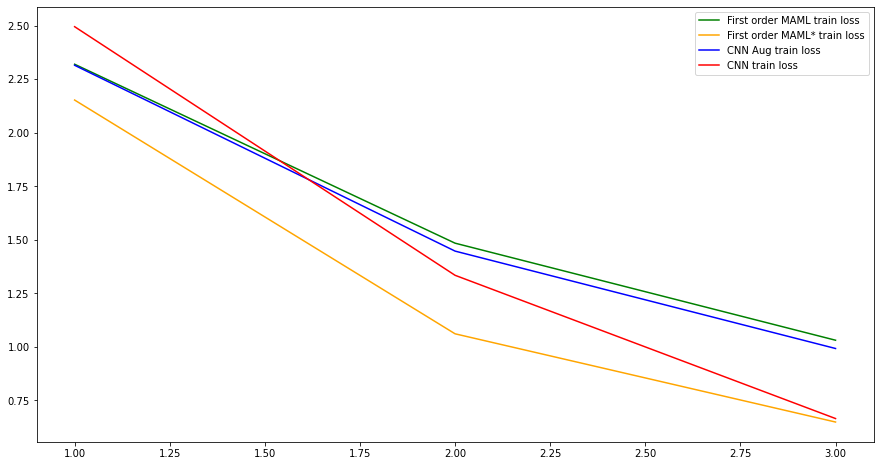

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.86607360839844
UC Epoch  2 Train Accuracy:  87.94642639160156
UC Epoch  3 Train Accuracy:  93.08036041259766
Test Accuracy:  73.4375
Test Top3 Accuracy:  93.26923370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.52678680419922
UC Epoch  2 Train Accuracy:  83.48213958740234
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  77.16345977783203
Test Top3 Accuracy:  93.81009674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.4375
UC Epoch  2 Train Accuracy:  89.28571319580078
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  74.33894348144531
Test Top3 Accuracy:  93.26923370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.22321319580078
UC Epoch  2 Train Accuracy:  84.15178680419922
UC Epoch  3 Train Accuracy:  91.07142639160156
Test Accuracy:  73.61779022216797
Test Top3 Accuracy:  93.20913696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.67857360839844
UC Epoch  2 Train Accuracy:  90.40178680419922
UC Epoch  3 Train Accuracy:  93.52678680419922
Test Accuracy:  75.84134674072266
Test Top3 Accuracy:  93.20913696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.65178680419922
UC Epoch  2 Train Accuracy:  84.375
UC Epoch  3 Train Accuracy:  90.84821319580078
Test Accuracy:  74.57933044433594
Test Top3 Accuracy:  93.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.75
UC Epoch  2 Train Accuracy:  81.02678680419922
UC Epoch  3 Train Accuracy:  90.17857360839844
Test Accuracy:  73.31730651855469
Test Top3 Accuracy:  92.42788696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.63392639160156
UC Epoch  2 Train Accuracy:  86.83036041259766
UC Epoch  3 Train Accuracy:  91.74107360839844
Test Accuracy:  74.69951629638672
Test Top3 Accuracy:  93.50961303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.33036041259766
UC Epoch  2 Train Accuracy:  85.26786041259766
UC Epoch  3 Train Accuracy:  90.625
Test Accuracy:  74.39904022216797
Test Top3 Accuracy:  91.52644348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.10713958740234
UC Epoch  2 Train Accuracy:  87.27678680419922
UC Epoch  3 Train Accuracy:  90.17857360839844
Test Accuracy:  74.33894348144531
Test Top3 Accuracy:  92.06730651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.22321319580078
UC Epoch  2 Train Accuracy:  87.72321319580078
UC Epoch  3 Train Accuracy:  93.75
Test Accuracy:  75.36058044433594
Test Top3 Accuracy:  92.1875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.75
UC Epoch  2 Train Accuracy:  81.02678680419922
UC Epoch  3 Train Accuracy:  90.40178680419922
Test Accuracy:  73.85816955566406
Test Top3 Accuracy:  91.88701629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.33928680419922
UC Epoch  2 Train Accuracy:  86.16071319580078
UC Epoch  3 Train Accuracy:  93.08036041259766
Test Accuracy:  73.61779022216797
Test Top3 Accuracy:  91.28605651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.77678680419922
UC Epoch  2 Train Accuracy:  86.38392639160156
UC Epoch  3 Train Accuracy:  94.19642639160156
Test Accuracy:  75.96154022216797
Test Top3 Accuracy:  91.40625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.75
UC Epoch  2 Train Accuracy:  84.375
UC Epoch  3 Train Accuracy:  91.74107360839844
Test Accuracy:  74.27884674072266
Test Top3 Accuracy:  92.42788696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.66963958740234
UC Epoch  2 Train Accuracy:  79.01786041259766
UC Epoch  3 Train Accuracy:  93.08036041259766
Test Accuracy:  76.14183044433594
Test Top3 Accuracy:  92.90865325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.54463958740234
UC Epoch  2 Train Accuracy:  82.14286041259766
UC Epoch  3 Train Accuracy:  92.63392639160156
Test Accuracy:  75.72115325927734
Test Top3 Accuracy:  93.08894348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.32142639160156
UC Epoch  2 Train Accuracy:  84.82142639160156
UC Epoch  3 Train Accuracy:  91.51786041259766
Test Accuracy:  74.09855651855469
Test Top3 Accuracy:  92.84855651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.75
UC Epoch  2 Train Accuracy:  84.375
UC Epoch  3 Train Accuracy:  89.28571319580078
Test Accuracy:  72.71634674072266
Test Top3 Accuracy:  92.54808044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.32142639160156
UC Epoch  2 Train Accuracy:  83.92857360839844
UC Epoch  3 Train Accuracy:  86.83036041259766
Test Accuracy:  73.61779022216797
Test Top3 Accuracy:  91.82691955566406
CNN_AugAccuracy on UC as an avg of  20 :  74.55528907775879
CNN_AugTopK on UC as an avg of  20 :  92.62319755554199


In [53]:
basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker,MAML_loss_tracker2)
avg_UC_test('CNN_Aug',20)

## Thoughts on UC


It is incrediably easy to overfit to UC mercer if we train each optimization scheme from sctrach as shown below. Since We know afte training on RESIC and then trasnfer learning on UC, we can say the model training on RESIC learned important features of the schenes that would otherwise not have been learned if it was just UC. Now when comparing optimization schemes, we can examine the testing accuracy of UC after training on RESIC and say which model's weights were primed for fast learning and fast adaption.


In [73]:
def fresh_train_UC(mtype,load):
    model = get_model(mtype=mtype,load=load)
    UC_MAML_learning_rate = 0.0006
    UC_CNN_learning_rate = 0.0006
    UC_epochs = 3
    UC_batch_size = 32
    UCtrain_loader,UCtest_loader = UC_get_data()
    model.fce = nn.Linear(1024, 21)
    model = model.to(device)
    #model.save('UC'+mtype)
    if mtype == 'CNN':
        print(mtype)
        model, epoch_tracker, CNN_Aug_loss_tracker,acc = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
    elif mtype == "MAML":
        print(mtype)
        model, _, _, _, _=  train(UC_epochs, UC_CNN_learning_rate, UC_CNN_learning_rate, UCtrain_loader, UCtest_loader, c_dim, mtype, augs=True)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)

    elif mtype == 'MAML2':
        print(mtype)
        model, _, _, _, _, =  train2(UC_epochs, UC_CNN_learning_rate, UC_CNN_learning_rate, UCtrain_loader, UCtest_loader, c_dim, mtype)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
        return acc
    elif mtype == 'MAMLnk':
        print(mtype)
        Params= Params = {'nways': 32, 'kshots': 1, 'in_channels': 3, 'hidden_size': 2, 
                  'innerStep': UC_MAML_learning_rate, 'MetaLR': UC_MAML_learning_rate, 'number_of_tasks': 32,
                  'Order': False, 'outerVSinner': 1, 'epoch': UC_epochs, 'aug': True,
                   'num_classes': 45}
        model,_,_,_,_,_ =trainMAML(mtype,model,UCtrain_loader,Params,val_loader,print_stride,nwaykshot=False)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)

CNN_acc = fresh_train_UC('CNN',load=False)
MAML_acc = fresh_train_UC('MAML',load=False)
MAML2_acc = fresh_train_UC('MAML2',load=False)
# MAMLnk_acc = fresh_train_UC('MAMLnk',load=False) dont run this get "CUDA error: device-side assert triggered" error, I think above calls demonstrate it enough how easy it is to overfit to the data with the best 3 models


    

CNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.55357360839844
UC Epoch  2 Train Accuracy:  97.32142639160156
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  30.288461685180664
Test Top3 Accuracy:  52.22355651855469
MAML


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saving...
Test Accuracy:  6.911057472229004
Test Top3 Accuracy:  20.19230842590332
MAML2
MAML2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saving...
Test Accuracy:  6.370192527770996
Test Top3 Accuracy:  15.745192527770996


# MAML second order on traditonal dataloader, tuned to best performance by hand 

In [146]:
mtype='MAML'

Params = {'nways': 32, 'kshots': 1, 'in_channels': 3, 'hidden_size': 2, 
                  'innerStep': .00005*5/16, 'MetaLR': .006*5/64, 'number_of_tasks': 32,
                  'Order': False, 'outerVSinner': 1, 'epoch': 150, 'aug': True,
                   'num_classes': 45}
model = get_meta_model(Params)

train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)
mtype='MAMLnk'
model.to(device)
if First_Train: model, epoch_tracker, MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topks, MAML_nk_train_acc = trainMAML(mtype,
                                                                                              model,
                                                                                              train_loader,
                                                                                              Params,
                                                                                              val_loader, 
                                                                                               print_stride1=print_stride
                                                                                              )
else: 
    model = get_model(mtype)
    MAML_nk_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_nk_val_topks=np.load(dir+mtype+'_val_topks.npy')
    MAML_nk_val_accs=np.load(dir+mtype+'_val_accs.npy')
acc,topk=make_test(model=model, testloader=test_loader)
avg_UC_test('MAMLnk_sgd',20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Module `ConvolutionalNeuralNetwork` has no parameter corresponding to the submodule named `classifier` in the dictionary `params` provided as an argument to `forward()`. Using the default parameters for this submodule. The list of the parameters in `params`: [features.0.weight, features.0.bias, features.2.weight, features.3.weight, features.3.bias, features.5.weight, features.6.weight, features.6.bias, features.8.weight, features.9.weight, features.9.bias, features.11.weight, features.12.weight, features.12.bias, features.14.weight, features.15.weight, features.15.bias, fce.weight, fce.bias].


On Epoch  10
Train Loss 0.0014963623077150375
Validation Accuracy:  19.407894134521484
Validation Top3 Accuracy:  35.52631759643555
On Epoch  20
Train Loss 0.0014768480308472165
Validation Accuracy:  23.601974487304688
Validation Top3 Accuracy:  41.94078826904297
On Epoch  30
Train Loss 0.001061118547878568
Validation Accuracy:  25.411184310913086
Validation Top3 Accuracy:  44.8190803527832
On Epoch  40
Train Loss 0.00099549705073947
Validation Accuracy:  26.726974487304688
Validation Top3 Accuracy:  48.19078826904297
On Epoch  50
Train Loss 0.0010575618062700545
Validation Accuracy:  27.713815689086914
Validation Top3 Accuracy:  47.532894134521484
On Epoch  60
Train Loss 0.0015429228071182494
Validation Accuracy:  28.865131378173828
Validation Top3 Accuracy:  49.5065803527832
On Epoch  70
Train Loss 0.0010455680744988578
Validation Accuracy:  28.453947067260742
Validation Top3 Accuracy:  49.25986862182617
On Epoch  80
Train Loss 0.0015118467429327586
Validation Accuracy:  29.769737243

ValueError: ignored

first order maml with 16 task inner loop l2 reg on n way k shot data, best learning rates normalized by batch size 

In [1]:
mtype='MAML2'
train_loader, val_loader, test_loader, c_dim, classes, ytrain = get_data(dir=dir, mtype=mtype,nwaykshot=True)
if First_Train: model, MAML_loss_tracker2, MAML_val_topks2, MAML_val_accs2, epoch_tracker, = train2(n_epochs, 
                                                                                                    learning_rate, 
                                                                                                    learning_rate1,
                                                                                                    train_loader, 
                                                                                                    val_loader, 
                                                                                                    c_dim, mtype,
                                                                                                    print_stride1 = print_stride,
                                                                                                    trainset= train_loader, 
                                                                                                    nwaykshot=True , 
                                                                                                    train_labels = ytrain,
                                                                                                    Params=Params)


train2(n_epochs=n_epochs, 
                                                                learning_rate=0.00045, 
                                                                learning_rate1=0.0001/8, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    MAML_loss_tracker2=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks2=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs2=np.load(dir+mtype+'_val_accs.npy')
avg_UC_test(mtype,20)

SyntaxError: ignored

## Scrap Work Area 

---

In [ ]:
#GRAD DIAGNOSTICS
'''
print("PARAMS YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA == pB).all())
print("GRAD YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA.grad == pB.grad))
'''

In [ ]:
# def trainmodel(dir,mtype,n_epochs,learning_rate_1,learning_rate_2):
#     train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)
#     make_example(train_loader=train_loader, classes=classes)
#     if mtype=='CNN' or mtype == "MAML":
#         model, loss_tracker, val_topk_tracker, val_acc_tracker, epoch_tracker = train(n_epochs=n_epochs, 
#                                                                     learning_rate=learning_rate_1, 
#                                                                     learning_rate1=learning_rate_2, 
#                                                                     train_loader=train_loader, 
#                                                                     val_loader=val_loader, 
#                                                                     c_dim=c_dim, 
#                                                                     mtype=mtype,print_stride1=1)
#     elif mtype == 'MAML2'
#          model, loss_tracker, val_topk_tracker, val_acc_tracker, epoch_tracker = train2(n_epochs=n_epochs, 
#                                                                     learning_rate=learning_rate_1, 
#                                                                     learning_rate1=learning_rate_2, 
#                                                                     train_loader=train_loader, 
#                                                                     val_loader=val_loader, 
#                                                                     c_dim=c_dim, 
#                                                                     mtype=mtype,print_stride1=1)
#     return model,test_loader,loss_tracker,val_topk_tracker,val_acc_tracker,epoch_tracker

# def AVG_n_model(dir,mtype,n_epochs,learning_rate_1,learning_rate_2,runs=5,UC_or_RES):
#     list_loss_tracker,list_val_topk_tracker,list_val_acc_tracker,testacc,testtopk = [],[],[],[],[]
#     for _ in range(runs):
#         if UC_or_RES=='RES'
#             model,test_loader,loss_tracker,val_topk_tracker,val_acc_tracker,epoch_tracker = trainmodel(dir,mtype,n_epochs,learning_rate_1,learning_rate_2)
#             list_loss_tracker.append(loss_tracker)
#             list_val_topk_tracker.append(val_topk_tracker)
#             list_val_acc_tracker.append(val_acc_tracker)

#             test_acc, test_topk  = make_test(model,test_loader)
#             testacc.append(test_acc)
#             testtopk.append(test_topk)
#         else:
#             testacc1 , testtopk1 = fresh_train_UC(mtype,load=True)
#             testacc.append(testacc1)
#             testtopk.append(testtopk1)


#     avg_loss = numpy.mean(numpy.array(list_loss_tracker), axis=0)
#     avg_valtopk = numpy.mean(numpy.array(list_val_topk_tracker), axis=0)
#     avg_valacc = numpy.mean(numpy.array(val_acc_tracker), axis=0)
    
#     test__valacc = numpy.mean(numpy.array(testacc), axis=0)
#     test___valacc = numpy.mean(numpy.array(testtopk), axis=0)

#     return avg_loss,avg_valtopk,avg_valacc,test__valacc,test___valacc





    
